First let's fit our supernova synthetic data from last time using GPR.

The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.\
But check out what's available in the kernels submodule of sklearn.gaussian_process.\
Plot the expectation value of the fit as well as the resulting 1- and 2- contours.
Interpret the results.

Note. To start with, feel free to tweak the hyperparameters manually. But, of course, a publication-quality result will require a cross-validation analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
path = r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities"
sys.path.append(path)
import plot_settings

In [7]:
data = np.genfromtxt(r'C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\Data\mu_z.txt', delimiter=' ')

In [8]:
z_sample  = data[:, 0]
mu_sample = data[:, 1]
dmu       = data[:, 2]

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ricca\AppData\Local\Temp\ipykernel_20160\2962798895.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


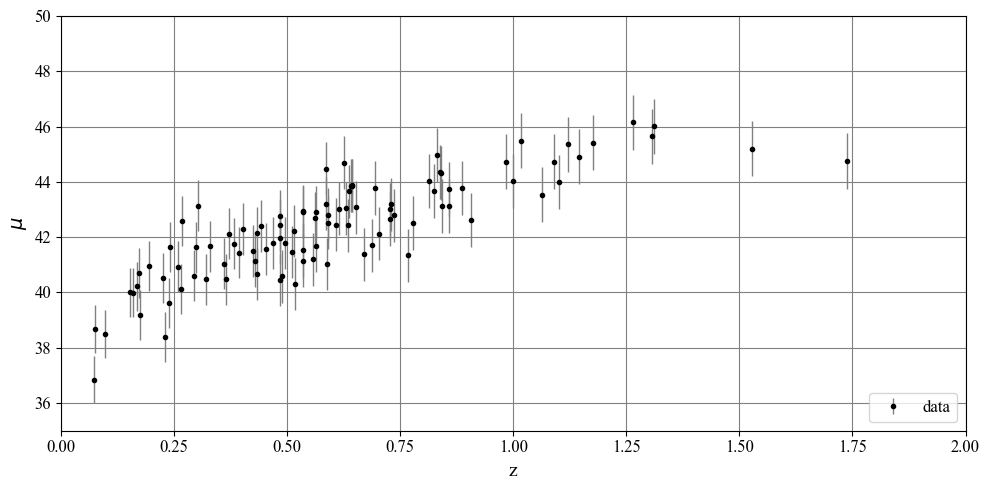

In [9]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

## GPR fit - Constant Kernel

In [120]:
from sklearn.model_selection import train_test_split

In [121]:
z_train, z_test, mu_train, mu_test = train_test_split(z_sample, mu_sample, test_size=0.2, random_state=42)

In [122]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [139]:
GPR = GaussianProcessRegressor(kernel=None, n_restarts_optimizer=10, random_state=42)

In [140]:
GPR.fit(z_train.reshape(-1,1), mu_train)

GaussianProcessRegressor(n_restarts_optimizer=10, random_state=42)

In [141]:
GPR.score(z_test.reshape(-1,1), mu_test)

0.6345686279850424

In [142]:
mean, std = GPR.predict(z_test.reshape(-1,1), return_std=True)

In [143]:
std

array([2.01193269e-06, 8.04244535e-06, 2.50474735e-06, 1.94007167e-06,
       1.96873045e-06, 3.91025607e-06, 3.45828954e-06, 1.99589359e-06,
       2.22995267e-06, 2.78324813e-06, 2.71168382e-06, 3.42441523e-06,
       3.10557860e-06, 2.88763589e-06, 2.85933443e-06, 2.75242236e-06,
       2.03683122e-06, 1.94041500e-06, 2.19755503e-06, 1.99720036e-06])

Text(0.5, 1.0, 'Gaussian Process Regression')

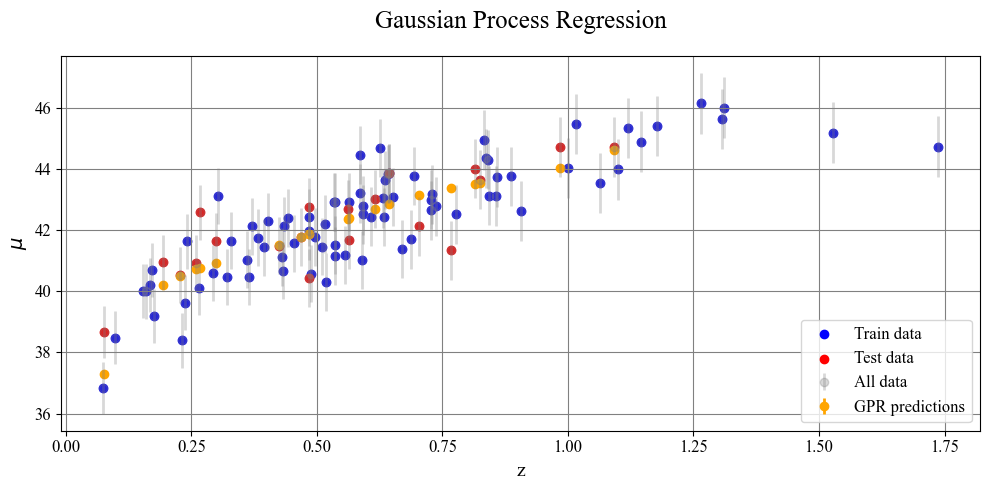

In [137]:
plt.errorbar(z_sample, mu_sample, dmu,  fmt='o', c='gray', label='All data', alpha=0.3)
plt.scatter(z_train, mu_train, c='blue', label='Train data')
plt.scatter(z_test, mu_test, c='red', label='Test data')
plt.errorbar(z_test, mean, std, fmt='o', c='orange', label='GPR predictions', ecolor='orange', barsabove=True)
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.title("Gaussian Process Regression")

We have to tune the lenght_scale of the RBF Kernel. We'll use Cross Validation

In [128]:
from sklearn.preprocessing import StandardScaler

In [159]:
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z_sample.reshape(-1, 1))
mu_scaled = scaler.fit_transform(mu_sample.reshape(-1, 1))
z_train_scaled = scaler.fit_transform(z_train.reshape(-1, 1))
mu_train_scaled = scaler.fit_transform(mu_train.reshape(-1, 1))
z_test_scaled = scaler.fit_transform(z_test.reshape(-1, 1))
mu_test_scaled = scaler.fit_transform(mu_test.reshape(-1, 1))

### Grid Search - CV

In [198]:
from sklearn.model_selection import KFold, cross_val_score

In [199]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [200]:
from sklearn.model_selection import GridSearchCV

In [209]:
# Composite kernel: RBF is k1, WhiteKernel is k2
kernel = RBF(length_scale=1.0)

# Model with composite kernel
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)

# Tune length_scale of RBF (k1)
param_grid = {
    "kernel__length_scale": np.linspace(0.1,1,10),
}

grid = GridSearchCV(model, param_grid, cv=kf, scoring="neg_mean_squared_error", )
grid.fit(z_scaled, mu_scaled)

c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a be

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GaussianProcessRegressor(kernel=RBF(length_scale=1),
                                                n_restarts_optimizer=5),
             param_grid={'kernel__length_scale': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='neg_mean_squared_error')

In [210]:
print("Best length scale:", grid.best_params_)
print("Best kernel:", grid.best_estimator_.kernel_)

Best length scale: {'kernel__length_scale': np.float64(0.1)}
Best kernel: RBF(length_scale=0.000593)


In [223]:
kernel = RBF(length_scale=1)
GPR = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

In [224]:
GPR.fit(z_train_scaled.reshape(-1,1), mu_train_scaled)

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=10,
                         random_state=42)

In [225]:
mean, std = GPR.predict(z_test_scaled.reshape(-1,1), return_std=True)

Text(0.5, 1.0, 'Gaussian Process Regression')

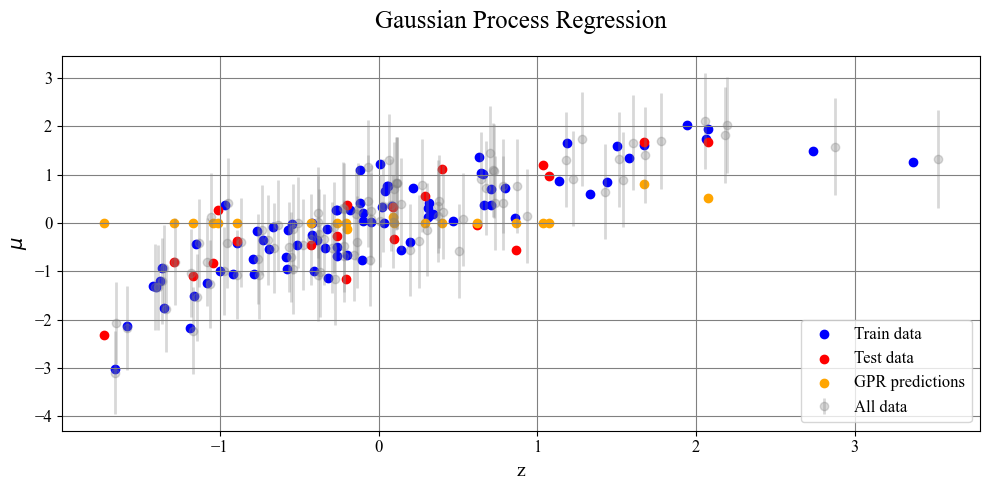

In [226]:
plt.errorbar(z_scaled.T[0], mu_scaled.T[0], dmu,  fmt='o', c='gray', label='All data', alpha=0.3)
plt.scatter(z_train_scaled, mu_train_scaled, c='blue', label='Train data')
plt.scatter(z_test_scaled, mu_test_scaled, c='red', label='Test data')
plt.scatter(z_test_scaled, mean, marker='o', c='orange', label='GPR predictions')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.title("Gaussian Process Regression")